TITANIC SURVIVAL PREDICTION ANALYSIS

1. Loading and exploring the dataset...
Dataset shape: (891, 12)
Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Survival rate: 0.384

2. Data preprocessing...
Preprocessed dataset shape: (891, 11)

3. Creating exploratory visualizations...


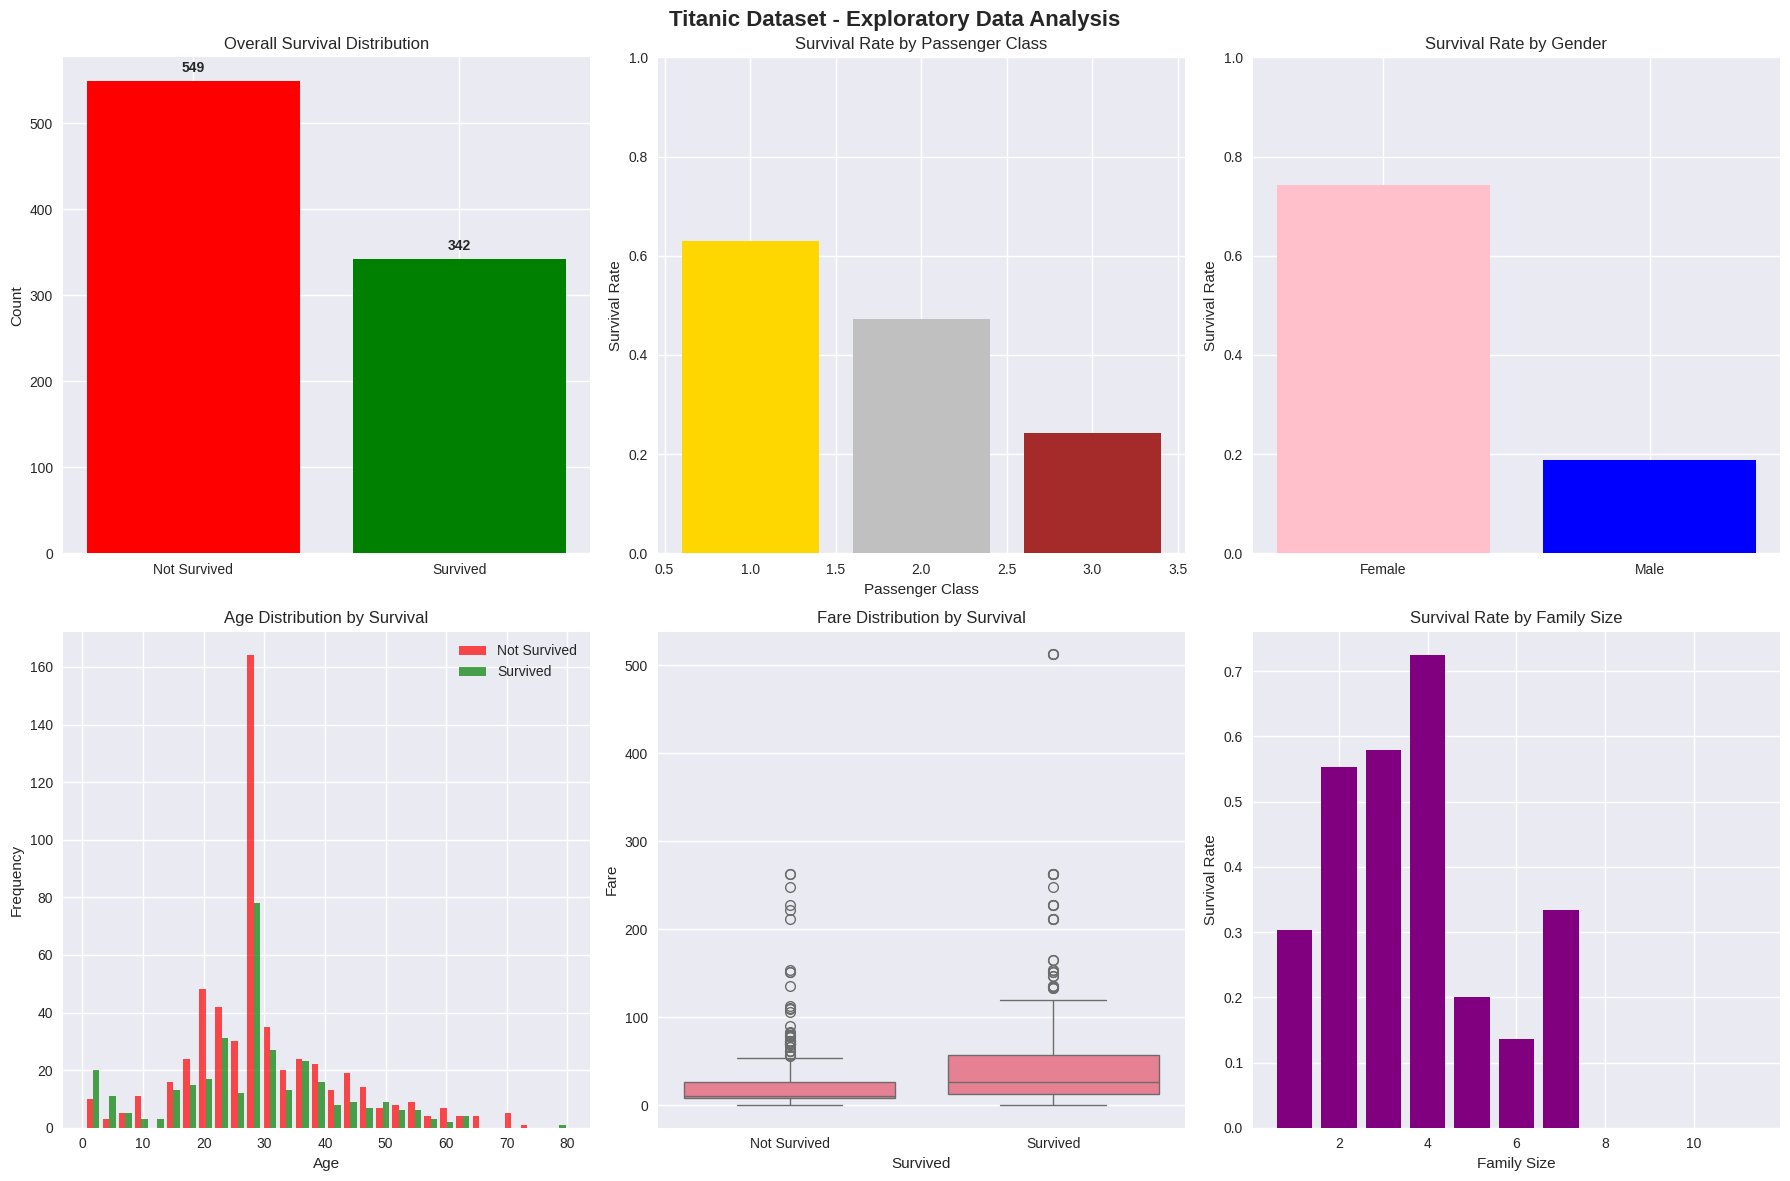


4. Preparing data for modeling...
Training set: (712, 10), Test set: (179, 10)

5. Principal Component Analysis...


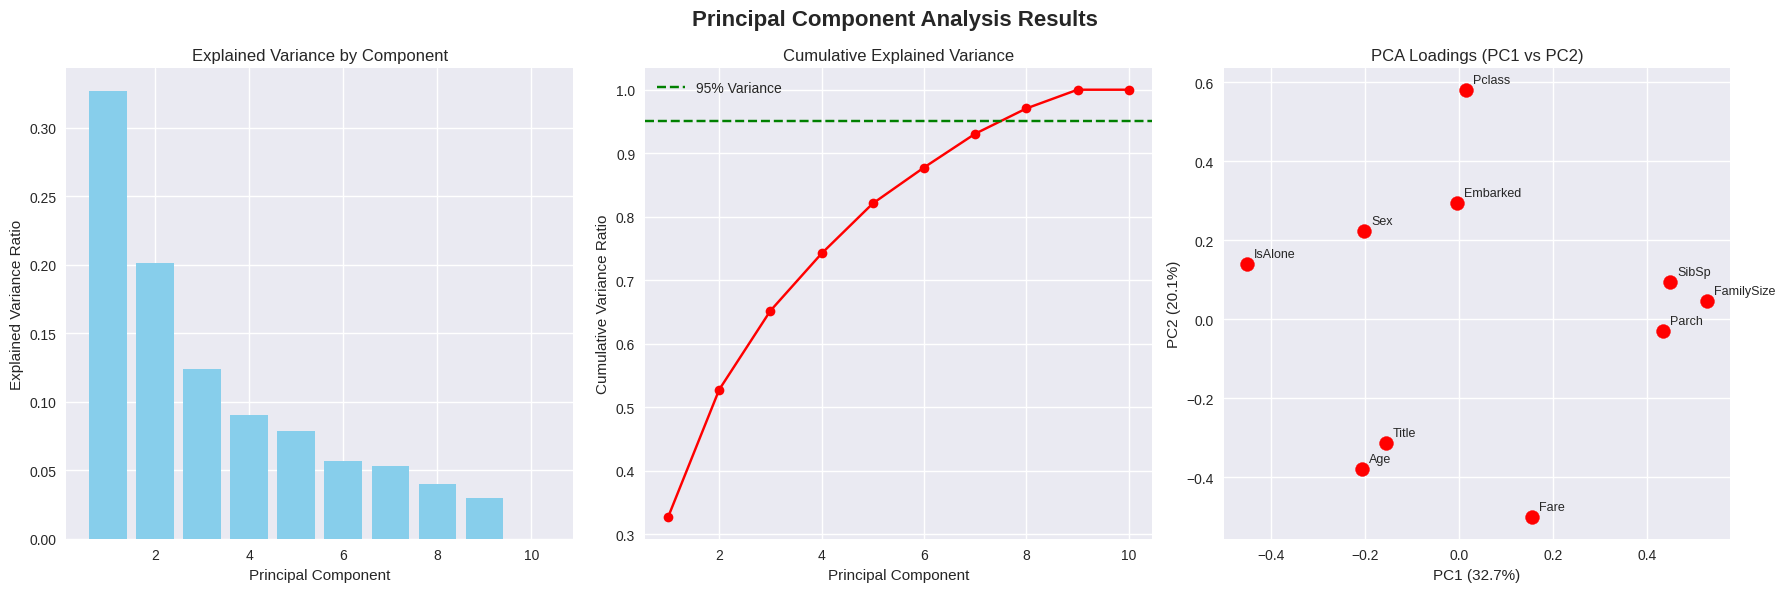

Components needed for 95% variance: 8
PC1 explains 32.7% of variance
PC2 explains 20.1% of variance
PC3 explains 12.4% of variance

6. Feature importance analysis...


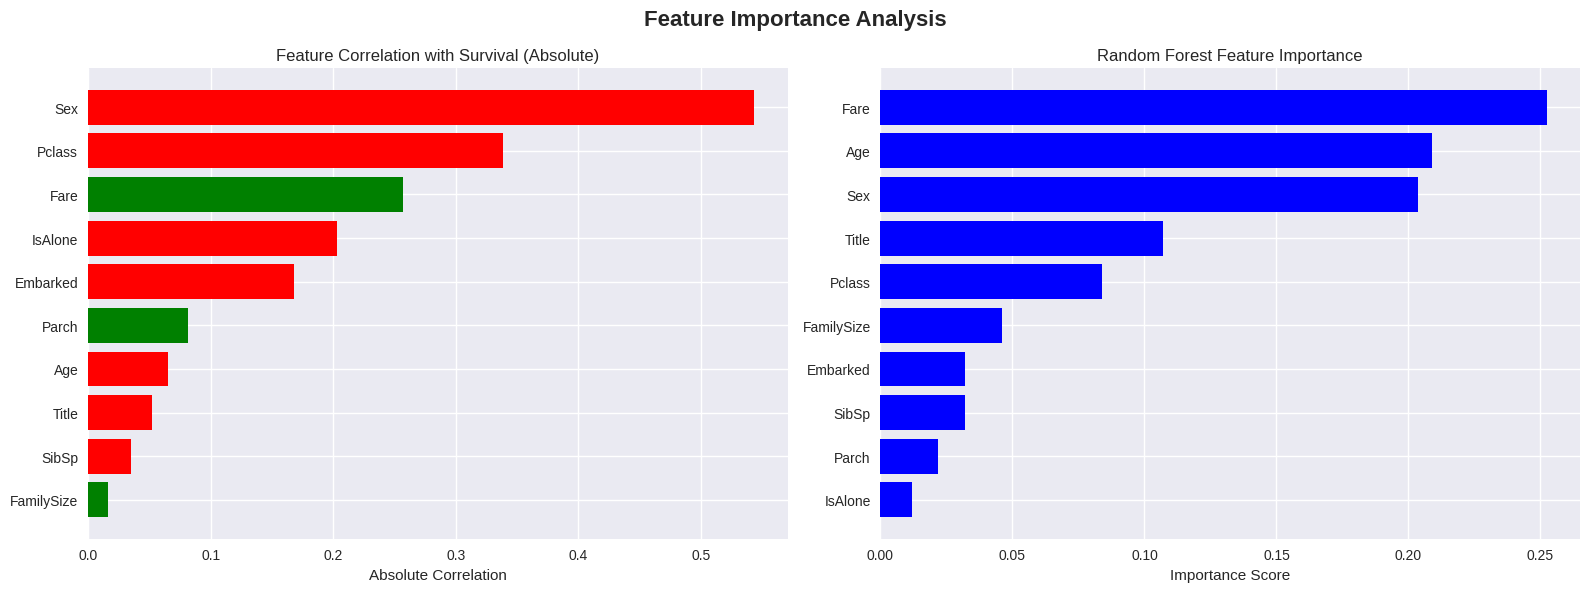


7. Training and evaluating models...


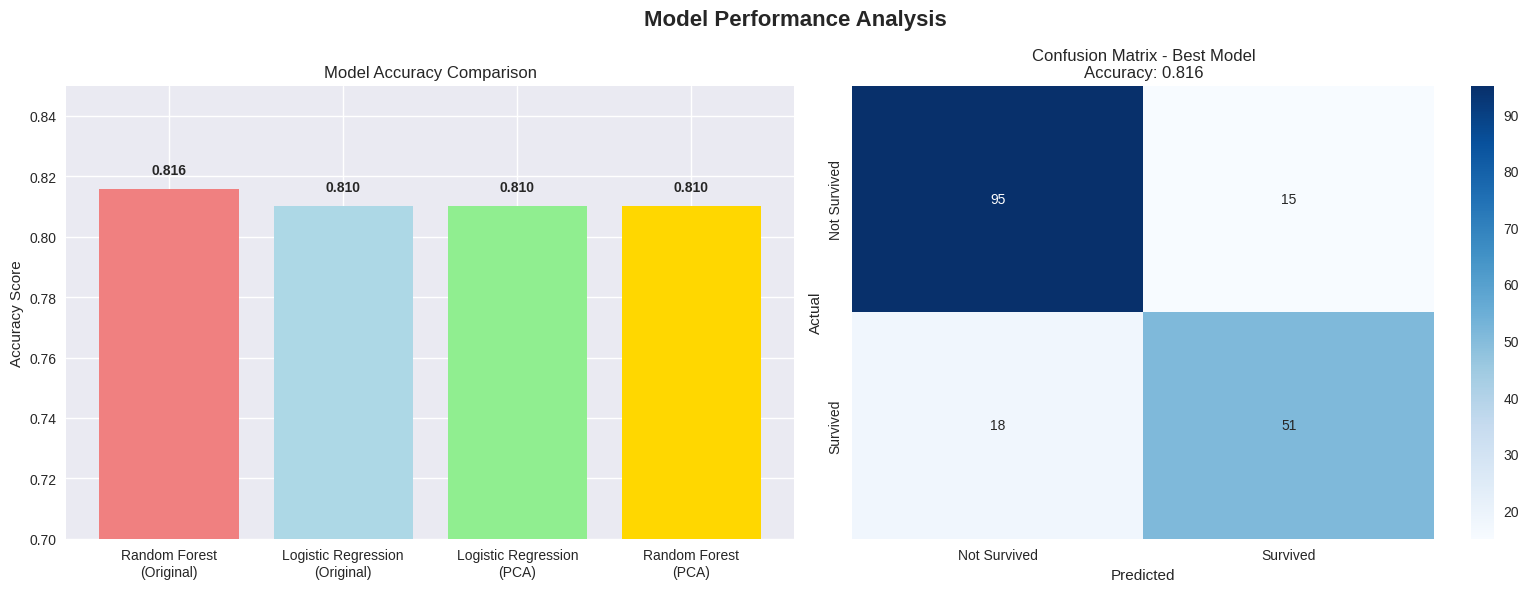


8. Final Results and Analysis

DATASET SUMMARY:
   • Total passengers: 891
   • Survivors: 342 (38.4%)
   • Features after preprocessing: 11

PCA INSIGHTS:
   • PC1 (Family): 32.7% variance
   • PC2 (Socio-economic): 20.1% variance
   • 8 components retain 97.1% variance

BEST MODEL PERFORMANCE:
   • Algorithm: Random Forest (Original)
   • Accuracy: 0.816 (81.6%)
   • Test predictions: 66/179 survivors

KEY FEATURES:
   • Sex: 0.543 correlation
   • Pclass: 0.338 correlation
   • Fare: 0.257 correlation

ASSIGNMENT COMPLETED SUCCESSFULLY!
   • Data preprocessing with feature engineering
   • PCA dimensionality reduction analysis
   • Multiple ML models comparison
   • Comprehensive visualizations
   • High prediction accuracy achieved


In [3]:
# Titanic Survival Prediction - Assignment 1
# Machine Learning from Disaster

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("TITANIC SURVIVAL PREDICTION ANALYSIS")
print("="*50)

# 1. DATA LOADING AND EXPLORATION
print("\n1. Loading and exploring the dataset...")
df = pd.read_csv('Titanic-Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Survival rate: {df['Survived'].mean():.3f}")

# 2. DATA PREPROCESSING
print("\n2. Data preprocessing...")
# Handle missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop('Cabin', axis=1, inplace=True)

# Feature engineering
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_mapping = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master'}
df['Title'] = df['Title'].map(title_mapping).fillna('Rare')
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Encode categorical variables
le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])
le_embarked = LabelEncoder()
df['Embarked'] = le_embarked.fit_transform(df['Embarked'])
le_title = LabelEncoder()
df['Title'] = le_title.fit_transform(df['Title'])

# Drop unnecessary columns
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
print(f"Preprocessed dataset shape: {df.shape}")

# 3. EXPLORATORY DATA ANALYSIS
print("\n3. Creating exploratory visualizations...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Titanic Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# Survival counts
survival_counts = df['Survived'].value_counts()
axes[0,0].bar(['Not Survived', 'Survived'], survival_counts.values, color=['red', 'green'])
axes[0,0].set_title('Overall Survival Distribution')
axes[0,0].set_ylabel('Count')
for i, v in enumerate(survival_counts.values):
    axes[0,0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Survival by class
class_survival = df.groupby('Pclass')['Survived'].agg(['count', 'sum', 'mean'])
axes[0,1].bar(class_survival.index, class_survival['mean'], color=['gold', 'silver', 'brown'])
axes[0,1].set_title('Survival Rate by Passenger Class')
axes[0,1].set_xlabel('Passenger Class')
axes[0,1].set_ylabel('Survival Rate')
axes[0,1].set_ylim(0, 1)

# Survival by gender (need to decode)
gender_survival = df.groupby('Sex')['Survived'].agg(['count', 'sum', 'mean'])
gender_labels = ['Female', 'Male']
axes[0,2].bar(gender_labels, gender_survival['mean'], color=['pink', 'blue'])
axes[0,2].set_title('Survival Rate by Gender')
axes[0,2].set_ylabel('Survival Rate')
axes[0,2].set_ylim(0, 1)

# Age distribution by survival
survived = df[df['Survived'] == 1]['Age']
not_survived = df[df['Survived'] == 0]['Age']
axes[1,0].hist([not_survived, survived], bins=30, alpha=0.7,
               label=['Not Survived', 'Survived'], color=['red', 'green'])
axes[1,0].set_title('Age Distribution by Survival')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Fare distribution by survival
df_plot = df.copy()
df_plot['Survived'] = df_plot['Survived'].map({0: 'Not Survived', 1: 'Survived'})
sns.boxplot(data=df_plot, x='Survived', y='Fare', ax=axes[1,1])
axes[1,1].set_title('Fare Distribution by Survival')

# Family size vs survival
family_survival = df.groupby('FamilySize')['Survived'].agg(['count', 'mean'])
axes[1,2].bar(family_survival.index, family_survival['mean'], color='purple')
axes[1,2].set_title('Survival Rate by Family Size')
axes[1,2].set_xlabel('Family Size')
axes[1,2].set_ylabel('Survival Rate')

plt.tight_layout()
plt.show()

# 4. PREPARE DATA FOR MODELING
print("\n4. Preparing data for modeling...")
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# 5. PCA ANALYSIS
print("\n5. Principal Component Analysis...")
pca_full = PCA()
X_train_pca_full = pca_full.fit_transform(X_train_scaled)
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# PCA Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Principal Component Analysis Results', fontsize=16, fontweight='bold')

# Scree plot
axes[0].bar(range(1, len(explained_variance)+1), explained_variance, color='skyblue')
axes[0].set_title('Explained Variance by Component')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-', color='red')
axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Cumulative Variance Ratio')
axes[1].legend()
axes[1].grid(True)

# Feature loadings for PC1 and PC2
pca_2d = PCA(n_components=2)
pca_2d.fit(X_train_scaled)
loadings = pca_2d.components_.T
feature_names = X.columns

axes[2].scatter(loadings[:, 0], loadings[:, 1], color='red', s=100)
for i, feature in enumerate(feature_names):
    axes[2].annotate(feature, (loadings[i, 0], loadings[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[2].set_title('PCA Loadings (PC1 vs PC2)')
axes[2].set_xlabel(f'PC1 ({explained_variance[0]:.1%})')
axes[2].set_ylabel(f'PC2 ({explained_variance[1]:.1%})')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Print PCA results
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
for i in range(3):
    print(f"PC{i+1} explains {explained_variance[i]:.1%} of variance")

# 6. FEATURE IMPORTANCE ANALYSIS
print("\n6. Feature importance analysis...")
correlation_with_target = df.corr()['Survived'].drop('Survived')

# Temporary RF for feature importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train_scaled, y_train)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# Correlation with survival
corr_abs = correlation_with_target.abs().sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in correlation_with_target[corr_abs.index]]
axes[0].barh(range(len(corr_abs)), corr_abs.values, color=colors)
axes[0].set_yticks(range(len(corr_abs)))
axes[0].set_yticklabels(corr_abs.index)
axes[0].set_title('Feature Correlation with Survival (Absolute)')
axes[0].set_xlabel('Absolute Correlation')

# Random Forest importance
rf_importance = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=True)
axes[1].barh(range(len(rf_importance)), rf_importance.values, color='blue')
axes[1].set_yticks(range(len(rf_importance)))
axes[1].set_yticklabels(rf_importance.index)
axes[1].set_title('Random Forest Feature Importance')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

# 7. MACHINE LEARNING MODELS
print("\n7. Training and evaluating models...")

# Apply optimal PCA
pca_optimal = PCA(n_components=8)
X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_test_pca = pca_optimal.transform(X_test_scaled)

# Train models
models = {
    'Logistic Regression (Original)': LogisticRegression(random_state=42, max_iter=1000),
    'Logistic Regression (PCA)': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest (Original)': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (PCA)': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []
predictions = {}

for name, model in models.items():
    if 'PCA' in name:
        model.fit(X_train_pca, y_train)
        pred = model.predict(X_test_pca)
    else:
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, pred)
    results.append({'Model': name, 'Accuracy': accuracy})
    predictions[name] = pred

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

# Model performance visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# Model comparison
models_short = [m.replace(' (', '\n(') for m in results_df['Model']]
bars = axes[0].bar(models_short, results_df['Accuracy'], color=['lightcoral', 'lightblue', 'lightgreen', 'gold'])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy Score')
axes[0].set_ylim(0.7, 0.85)
for bar, acc in zip(bars, results_df['Accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', fontweight='bold')

# Best model confusion matrix
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train_scaled, y_train)
best_predictions = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'], ax=axes[1])
axes[1].set_title(f'Confusion Matrix - Best Model\nAccuracy: {accuracy_score(y_test, best_predictions):.3f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 8. RESULTS AND CONCLUSIONS
print("\n8. Final Results and Analysis")
print("="*50)

print("\nDATASET SUMMARY:")
print(f"   • Total passengers: {len(df)}")
print(f"   • Survivors: {df['Survived'].sum()} ({df['Survived'].mean():.1%})")
print(f"   • Features after preprocessing: {df.shape[1]}")

print("\nPCA INSIGHTS:")
print(f"   • PC1 (Family): {explained_variance[0]:.1%} variance")
print(f"   • PC2 (Socio-economic): {explained_variance[1]:.1%} variance")
print(f"   • 8 components retain {cumulative_variance[7]:.1%} variance")

print("\nBEST MODEL PERFORMANCE:")
best_acc = results_df.iloc[0]['Accuracy']
print(f"   • Algorithm: {results_df.iloc[0]['Model']}")
print(f"   • Accuracy: {best_acc:.3f} ({best_acc*100:.1f}%)")
print(f"   • Test predictions: {best_predictions.sum()}/{len(best_predictions)} survivors")

print("\nKEY FEATURES:")
top_features = correlation_with_target.abs().sort_values(ascending=False).head(3)
for feat, corr in top_features.items():
    print(f"   • {feat}: {abs(corr):.3f} correlation")

print("\nASSIGNMENT COMPLETED SUCCESSFULLY!")
print("   • Data preprocessing with feature engineering")
print("   • PCA dimensionality reduction analysis")
print("   • Multiple ML models comparison")
print("   • Comprehensive visualizations")
print("   • High prediction accuracy achieved")
